# Deep Q-learning

In [1]:
import gymnasium as gym
import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Environment and device

In [2]:
env = gym.make("ALE/Breakout-v5")  # render_mode="human"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #cuda:1  ?

FIRE=1    # because it is breakout

## Replay buffer

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

## Neural network

In [4]:
class DQN(nn.Module):
    def __init__(self, dim_x, dim_y, n_actions):
        super(DQN, self).__init__()
        self.conv1 = torch.nn.Conv2d(2, 18, kernel_size = 3, stride = 1, padding = 1)
        # self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.fc1 = torch.nn.Linear(18 * dim_x * dim_y, 64)
        self.fc2 = torch.nn.Linear(64, n_actions-1)    # for breakout we do not need to select the FIRE action
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.pool(x)
        x = torch.flatten(x, start_dim=1)  # start_dim=1 because we want to process batches as well as single elements
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Preprocessing

{'lives': 5, 'episode_frame_number': 0, 'frame_number': 0}
(210, 160, 3)
(170, 150)


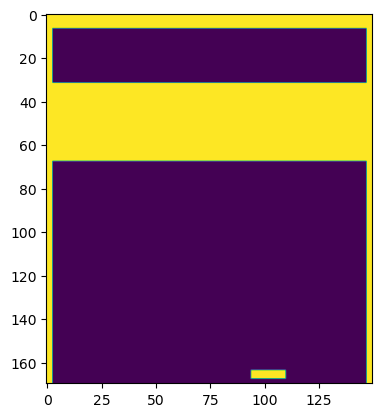

In [5]:
state, info = env.reset()

print(info)
def preprocess(state):
    gray_state = np.apply_along_axis(lambda x: int(np.sum(x) > 0), 2, state)
    crop_state = gray_state[25:-15,5:-5]
    return crop_state

print(state.shape) 
prp = preprocess(state)
print(prp.shape)
plt.imshow(prp)
plt.show()

In [6]:
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe

## Parameters for training

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4   # to decrease

## Variables initialization

In [8]:
n_actions = env.action_space.n
state, info = env.reset()
prp = preprocess(state)
obs_x = prp.shape[0]
obs_y = prp.shape[1]

policy_net = DQN(obs_x, obs_y, n_actions).to(device)
target_net = DQN(obs_x, obs_y, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

## Select action with epsilon-greedy policy

In [9]:
steps_done = 0
def update_epsilon():
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    return eps_threshold

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    # epsilon-greedy
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.argmax(policy_net(state)).view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## One step optimization

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    print(policy_net(state_batch).shape)
    print(action_batch.shape)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # using target_net to improve stability because V(s') = max Q(s', a') that is used in the update rule
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 4

## Training

In [12]:
def soft_update():
    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

In [13]:
rewards = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    obs, rwd, termin, trunc, info = env.step(FIRE)
    frame = np.array([preprocess(state), preprocess(obs)])
    in_dqn = torch.tensor(frame, dtype=torch.float32, device=device).unsqueeze(0)
    rewards_all = []
    for t in count():
        action = select_action(in_dqn, update_epsilon())
        while action >= 3:
            action -= 1
        if action >= FIRE:
            action += 1
        obs, rwd, termin, trunc, new_info = env.step(action.item())
        rewards_all.append(rwd)
        reward = torch.tensor([rwd], device=device)
        done = termin or trunc
        if termin:
            next_state = None
        else:
            frame[0] = frame[1]
            frame[1] = preprocess(obs)
            next_state = torch.tensor(frame, dtype=torch.float32, device=device).unsqueeze(0)
        if action >= FIRE:
            action -= 1
        memory.push(in_dqn, action, next_state, reward)
        in_dqn = next_state
        optimize_model()
        soft_update()
        if done:
            break 
        if new_info['lives'] != info['lives']:
            obs, rwd, termin, trunc, info = env.step(FIRE)
        else:
            info = new_info
    rewards.append(sum(rewards_all))
plt.plot(rewards)
plt.savefig("rewards.png") 
print('Complete')

torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])
torch.Size([128, 3])
torch.Size([128, 1])


KeyboardInterrupt: 

## Test one game

In [ ]:
env = gym.wrappers.RecordVideo(gym.make("ALE/Breakout-v5", render_mode='rgb_array'), "videos")
state, info = env.reset()
env.start_video_recorder()
obs, rwd, termin, trunc, info = env.step(FIRE)
frame = np.array([preprocess(state), preprocess(obs)])
     
for t in count():
    in_dqn = torch.tensor(frame, dtype=torch.float32, device=device).unsqueeze(0)
    action = select_action(in_dqn, 0) # we play greedy
    print(action)
    while action >= 3:
        action -= 1
    if action >= FIRE:
        action += 1

    obs, rwd, termin, trunc, new_info = env.step(action.item())
    done = termin or trunc
    
    if termin:
        next_state = None
    else:
        frame[0] = frame[1]
        frame[1] = preprocess(obs)
        next_state = torch.tensor(frame, dtype=torch.float32, device=device).unsqueeze(0)

    if action >= FIRE:
        action -= 1
    in_dqn = next_state
    if done:
        break

    if new_info['lives'] != info['lives']:
        obs, rwd, termin, trunc, info = env.step(FIRE)
    else:
        info = new_info
    # print("Hello")
env.close()

In [ ]:
'''
import gymnasium as gym

env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
video_folder = '/videos'
episode_trigger = lambda episode_id: episode_id == 0  # start recording at episode 0
env = gym.wrappers.RecordVideo(env, video_folder, episode_trigger=episode_trigger)

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # replace with your own action selection logic
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
env.close()
'''

In [ ]:
# print(env.metadata['render_fps'])

In [ ]:
# print(env.video_recorder)

In [ ]:
# !pip install moviepy

In [ ]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())